In [83]:
library(magrittr)
library(caret)
library(zeallot)
library(Matching)
library(tidyverse)
source("R/simulation_scenarios.R")
source("R/hte_caret.R")
source("R/hte_cv.R")

In [3]:
# returns the index of the observation most similar to the observation in that position:
# i.e. (1->5), (2->3), ... 
find_matches = function(x, w) {
    index = 1:length(w)
    treated_match = Match(Tr=w, X=x, replace=T, estimand="ATT") 
    control_match = Match(Tr=!w, X=x, replace=T, estimand="ATT")
    subject = index[c(treated_match$index.treated, control_match$index.treated)] # all subjects
    match = index[c(treated_match$index.control, control_match$index.control)] # their matches
 
    match_sorted = rep(NA,length(index))
    match_sorted[subject] = match
    return(match_sorted)
}

In [4]:
make_matrix = function(x) stats::model.matrix(~.-1, x)
covariates = function(data) data %>% dplyr::select(starts_with("covariate")) %>% make_matrix()
treatment = function(data) data$treatment
outcome = function(data) data$outcome
decompose_df = function(data) list(covariates(data), treatment(data), outcome(data))
subset_rows = function(items, index) {
    items %>% map(function(item) {
        if (is.vector(item)) item[index]
        else if (is.array(item)) item[index,]
        else stop("Don't know what to do with item of this type")
    })
}

iptw = function(p,w) 1/(1-w + 2*w*p - p)

In [6]:
model_specs = list(
gbm = list(
    tune_grid = expand.grid(
        n.trees = seq(1,501,40), 
        interaction.depth=3, 
        shrinkage = 0.1, 
        n.minobsinnode=3),
    extra_args = list(
        verbose=F, 
        bag.fraction=0.5)),
glmnet = list(
    tune_grid = expand.grid(
       alpha=c(0,0.5,1),
       lambda=exp(seq(-5,2,0.4))),
    extra_args = list()))

In [7]:
DGP = powers_DGPs()[[11]]

In [8]:
c(n_train, n_val, n_test) %<-% list(1000, 1000, 1000)
create_data(DGP, n_train + n_val + n_test) %->%
    c(data, aux_data)
itrain = 1:n_train
ival = itrain + n_train
itest = ival + n_val

In [9]:
c(x,w,y) %<-% decompose_df(data)

estimate many treatment effects models on the training set and get validation + test set estimates from each (TRAINING -> VALIDATION+TEST)

In [10]:
estimates = list(
        S=S_learners_pred_test, 
        T=T_learners_pred_test, 
        R=R_learners_pred_test) %>%
    imap(function(learner, learner_type){
        learner(itrain, x, w, y, model_specs) %>% # uses train to predict on val/test
        mutate(model = str_c(learner_type, model, sep="$"))
    }) %>% bind_rows

Warning message:
: package ‘bindrcpp’ was built under R version 3.2.5

cross-estimate mean outcome and propensity score using cross-validated models on the validation set and match on validation set (VALIDATION)

In [44]:
    list(x,w,y) %>% 
    subset_rows(ival) %->%
c(x_val, w_val, y_val)
mu_hat_val = cross_validated_cross_estimation(x_val, y_val, model_specs)
p_hat_val = cross_validated_cross_estimation(x_val, w_val, model_specs)
c(mu0_hat_val, mu1_hat_val) %<-% S_learner_cv_ce(x_val, w_val, y_val, model_specs)
matches = find_matches(x_val, w_val)

use those auxiliary data (mean_outcome, pscore, match) and (est_outcome, est_effect) on the validation set to estimate all validation metrics (VALIDATION)

In [84]:
metrics = list(
    mse = bundle_mse,
    wmse = bundle_wmse,
    r_objective = bundle_r_objective,
    match_mse = bundle_match_mse,
    trans_mse = bundle_trans_mse,
    match_mdc = bundle_match_mdc,
    trans_mdc = bundle_trans_mdc,
    ip_value = bundle_ip_value,
    dml_value = bundle_dml_value,
    gain = bundle_gain,
#     c_benefit = bundle_c_benefit,
    qini = bundle_qini,
#     ip_value_auc = bundle_ip_value_auc,
    random = bundle_random)
val_bundle = list(
    matches = find_matches(x_val, w_val),
    w = w_val,
    y = y_val,
    mu0 = mu0_hat_val,
    mu1 = mu1_hat_val,
    pseudo_outcome = (y_val - mu_hat_val)/(w_val - p_hat_val),
    weight = (w_val - p_hat_val)^2,
    iptw = iptw(p_hat_val, w_val)
    )

In [88]:
val_estimates_grp = estimates %>% 
    filter(index<=max(ival)) %>%
    group_by(model)
val_metrics = metrics %>% imap(function(metric, metric_name) {
    val_estimates_grp %>% 
        summarize(!!metric_name:=metric(val_bundle, y_hat, tau_hat))
}) %>% reduce(inner_join, by="model")

In [87]:
vignette("programming", "dplyr")

starting httpd help server ... done


In [125]:
head(val_metrics %>% arrange(-r_objective)) %>% data.frame

,model,mse,wmse,r_objective,match_mse,trans_mse,match_mdc,trans_mdc,ip_value,dml_value,gain,qini,random
1,R$gbm@481~3~0.1~3,205.0971,133.8437,18.63856,183.5369,202.6575,-1.097082,-1.525081,0.3588307,1.102509,1.863761,-143525.1,0
2,T$glmnet@0.5~6.04964746441295,9.269185,9.842852,17.79278,13.77918,30.02593,-0.504451,-0.9864317,-0.1798182,-2.190453,1.545512,-124834.9,0
3,T$glmnet@1~2.71828182845905,9.269185,9.842852,17.79278,13.77918,30.02593,-0.504451,-0.9864317,-0.1798182,-2.190453,1.545512,-124834.9,0
4,T$glmnet@1~4.05519996684468,9.269185,9.842852,17.79278,13.77918,30.02593,-0.504451,-0.9864317,-0.1798182,-2.190453,1.545512,-124834.9,0
5,T$glmnet@1~6.04964746441295,9.269185,9.842852,17.79278,13.77918,30.02593,-0.504451,-0.9864317,-0.1798182,-2.190453,1.545512,-124834.9,0
6,R$gbm@441~3~0.1~3,185.1279,120.6657,17.17469,164.3889,182.9183,-1.123185,-1.545595,0.3793451,1.296131,1.89836,-154042.8,0


In [80]:
# will need a function to eval true value on test set

apply tMSE and value to test-set estimates from all models using (true_effect) and (est_effect) (TEST)

In [ ]:
true_metrics = list(
    function(tau_
)

In [117]:
names(estimates)

[1] "tau_hat" "y_hat"   "model"   "index"

In [126]:
tau_hat_derp1 = estimates %>% 
    filter(min(itest)<=index) %>%
    filter(model == "R$glmnet@0~1.22140275816017") %>%
    pull(tau_hat)

tau_hat_derp2 = estimates %>% 
    filter(min(itest)<=index) %>%
    filter(model == "R$gbm@481~3~0.1~3") %>%
    pull(tau_hat)

In [128]:
tau_hat_derp2

[1] -4.503157e+00 -9.429413e-01  5.308577e+00 -2.479048e+00 -4.283798e+00
   [6]  1.395986e+00  3.207343e+00  1.355141e+00 -1.105385e+01  1.414555e+00
  [11]  3.758837e+00  2.225967e+00  6.276210e+00 -3.693756e-01 -2.517818e+00
  [16]  1.561600e+00  2.232389e+00  3.272540e+00  3.304206e+00 -8.660074e+00
  [21]  3.792896e+00 -1.376716e+01 -5.896608e-01  8.394819e-02 -7.371382e-01
  [26]  2.747971e-01  1.607286e+01  6.155801e+00 -3.626106e+00  8.183535e+00
  [31]  2.811109e+00 -1.110260e+00 -2.409188e+00 -1.449467e+00 -6.618533e+00
  [36]  4.363509e+00 -2.719674e+00  2.701720e-01 -1.564277e+00  1.975052e+01
  [41]  1.607186e-01  2.262976e+01 -2.005128e+00  1.917592e+00  1.655937e+00
  [46]  2.603924e+00  3.635109e+00 -1.991932e+00 -4.665437e+00  2.034863e+00
  [51] -1.280987e+00 -7.563807e+01  2.138164e+00 -3.480692e+00  7.280084e+00
  [56] -2.402427e+00  1.392399e+01  4.085294e+00 -2.440774e+00  4.145640e+00
  [61] -4.012669e+00  2.451171e+00  1.027657e+00  1.959050e-01 -2.761803e+00
  [66] -5.537325e+00 -5.351929e+00  6.310913e-01 -1.330791e+01 -5.431538e+00
  [71]  3.710645e-01  3.684054e+00  1.189374e+00  4.465669e-02 -4.583350e+00
  [76]  2.415001e+00  1.905677e+00 -3.075559e+00 -3.220131e+00 -4.902205e+00
  [81]  1.451035e+00  2.405553e+00 -3.342040e+00  1.636926e+00 -3.428578e+00
  [86]  1.119740e+00  3.566731e-01 -1.613771e+00  3.114806e+00 -8.303275e-01
  [91] -9.756637e-01  1.015077e+00  8.415054e-01 -2.373253e+00 -1.839439e+00
  [96] -2.814978e+00 -1.024349e+01  1.134721e+00 -7.896206e-01  3.715978e+00
 [101]  2.254527e-01  1.785096e+00 -3.325695e+00  1.606569e+00 -5.324548e+00
 [106]  4.942025e+00  4.930911e+00 -2.501227e+00  3.592354e+01 -2.956964e+00
 [111]  8.676891e-01 -5.179434e+00 -1.239328e-01 -4.297186e+00 -3.771979e+00
 [116]  3.354920e+00 -3.481931e-01 -4.093412e+00  9.767458e-01  3.459024e-01
 [121] -3.383248e+00  1.264341e+00  9.902201e-01  5.187088e+00  9.509284e-01
 [126]  9.987016e+00  1.006035e+00  3.481506e+00  1.242721e+00 -4.473579e+00
 [131] -2.955162e+00 -3.871823e+00 -1.536583e+00 -2.842565e+00  4.291346e+00
 [136] -2.776711e+00  1.116078e+00  1.763383e+01 -1.758586e+00  3.508789e+00
 [141]  5.813074e-01 -5.959981e+00  1.101686e+00  1.354020e+01  5.042008e+00
 [146]  8.872299e-02  1.029501e+00  1.223810e+00 -4.300461e+00  2.910669e+00
 [151]  4.533132e+00 -3.746802e-01 -1.342442e+00 -2.116700e+00 -1.132231e+02
 [156]  3.031150e+00  3.738038e-01  1.780371e+01 -1.856069e+00  1.031745e+02
 [161]  1.163084e+01 -3.659516e+00 -3.191052e+00  8.985246e+00  4.063483e+00
 [166]  1.066125e+00 -8.123189e-01  6.531358e+01  4.070275e+00  2.492254e+00
 [171]  2.015676e+01 -3.817691e+00  2.760760e+00  6.664071e+00 -7.305188e+00
 [176] -4.274017e+00 -3.028753e+00 -6.777388e+00  1.122062e+00  8.626148e+00
 [181]  3.175129e+00 -4.251402e+00 -1.005920e+01 -1.901984e-02 -2.521823e+00
 [186] -1.749470e+00  8.811694e+00  1.514696e+00  3.621343e+00 -4.577146e+00
 [191]  6.654595e+00  7.849518e+00 -5.980429e-02  4.166719e+00 -8.454720e+00
 [196]  3.717646e+00 -1.152871e+01  1.070450e+00 -1.586987e+00  1.315693e+01
 [201] -2.635910e+00  8.519182e-01 -1.031437e+01 -4.847573e+00  1.013934e+01
 [206] -1.914641e+00  3.496064e+00  7.898258e-02 -2.268437e+00 -1.379787e+01
 [211]  3.063405e+00  8.897118e-01  3.214764e+00 -2.456015e+00 -7.872215e+00
 [216]  2.861428e+00  2.602999e+00 -4.444258e+00 -1.386816e+01 -1.933303e+00
 [221] -2.936192e+00 -1.196656e+00 -2.305489e+00 -9.428564e-01 -2.614571e+00
 [226]  1.017132e+01 -1.560093e+00 -1.597331e+00  6.497720e+00 -2.305084e+00
 [231] -3.414551e+00 -9.391507e-01  4.645536e-01 -3.320225e+00 -2.940211e+00
 [236] -1.426292e+00  4.922953e+00  7.440251e+01  4.514633e-01  5.287584e+00
 [241] -1.810805e+01 -4.544673e+00  4.353227e+00 -2.616178e+00  3.586770e+00
 [246]  2.715961e+00 -1.751284e+00  7.186801e+00 -7.953059e+00 -1.893375e+00
 [251] -7.243431e-02  3.645469e+01 -2.230227e+00  5.823588e+00  1.989652e+00
 [256]  5.691478e+00  2.310690e+01 -3.828535e+00  2.437360e+00  2.947959e+00

In [127]:
tau_hat_derp1

[1]  -4.281668382  -0.426056048   5.191593999  -2.622291285   4.128622941
   [6]  -0.525232243   3.293706520   0.942697163  -4.826755337  -0.603239883
  [11]  -5.812420161   1.595180423   5.047665531  -0.254941822  -3.018629865
  [16]   0.704872331   1.894703927   1.684316323   5.453868101  -5.431031390
  [21]   3.385021689  -5.595366608  -0.633254288   0.250763262  -2.016263425
  [26]  -0.037116716   5.497919044   5.304054831  -2.284322595   2.774449258
  [31]   3.172983697  -1.040062887  -1.229143445  -0.291593035  -1.577129666
  [36]   2.936900133  -1.434877664   0.525897786  -4.209442639   5.948743970
  [41]   0.017923149   7.500074947  -1.693974124   0.809599728  -5.886812578
  [46]   2.165862529   3.782102896  -0.789341835  -5.425793252   0.962264623
  [51]  -4.101086630 -11.155135897   0.301824576  -3.688480564   3.711928112
  [56]  -1.210755607   6.800556317   3.305190892  -2.310871296   3.516129449
  [61]  -2.499963704   1.313479239   2.169059677  -4.465320300  -1.055432333
  [66]  -4.343210568  -5.293411972   0.414609094  -7.637207539  -4.218525151
  [71]  -0.715904230   4.790724335   5.718893728  -3.310252871  -2.002297032
  [76]   0.200831720   1.969161768  -2.767809354  -1.862691540  -4.655334601
  [81]   3.061072272   0.942657334   2.718278245  -0.780932421  -2.172761020
  [86]  -0.191624324   0.181412192  -1.499840709   4.416735438  -5.640875737
  [91]  -1.498870493  -4.098670480   4.205171088  -2.662079320  -1.342408724
  [96]  -3.050647436  -7.193933458  -0.727081103  -0.853076811   2.736809703
 [101]   5.970318144   1.013331172  -3.715354983   1.730443071  -4.593493246
 [106]   3.084762347   5.137741188  -1.353315731  -7.143888402  -2.823777341
 [111]   0.143225980  -4.581405114  -1.094859397  -4.036083542  -3.108554510
 [116]   0.600724864   0.901722357  -1.380208255   1.082166388   2.708506365
 [121]  -3.673555679   2.549975320   0.576892420   2.139936141   0.503049212
 [126]   6.960047190   1.492007564   0.374982901   1.707411706  -4.255098317
 [131]   0.973877663  -3.717039442  -6.644083509  -1.634718626   1.995953117
 [136]  -2.145753728   1.682657677   4.752228894  -0.989349089   1.827408641
 [141]   0.617471749  -5.013863994   2.562461123   6.720099764   3.804090962
 [146]   0.850590586  -0.032352045  -0.270499175  -2.028124912   1.012190232
 [151]  -5.896059594  -0.190484541  -0.472818865  -1.071819012 -10.459357913
 [156]   3.877820102   4.795528281  -6.449723250   4.506659585   8.761152935
 [161]   4.742342321  -3.777638454  -2.735927446   4.692455495   1.440895300
 [166]   0.766799104  -3.035704614   9.442639096   2.373999154   6.440574733
 [171]  -6.557732466  -3.723249538   1.590294479   4.024226780  -1.461996798
 [176]  -4.116133001  -1.941863764  -6.451169854   0.198996396   6.018713692
 [181]   0.032789253  -3.087822342  -5.117996627   4.608508253  -0.763986078
 [186]  -3.383192543  -6.331539864   1.903556600  -0.821484622  -3.572101418
 [191]  -5.830190566   7.009453585   1.412940176   3.248562612  -6.042254506
 [196]   5.344339819   4.461920287   0.613385677  -1.592948559   5.245144279
 [201]  -2.653463774   1.302649368   6.141198830   2.533220112   4.745253731
 [206]  -2.500683773   4.698014552   4.466917445  -1.965645153  -6.027494066
 [211]   5.129085571   0.136424484   3.381749822  -1.810405660  -5.553528060
 [216]  -0.386205064   1.592881705  -2.917830965  -7.369345999  -1.567426295
 [221]   3.726157800  -0.847867885  -2.289401096  -7.309630372   0.786374113
 [226]   3.217778051  -1.260018346   0.020052064   5.056798265  -1.858286225
 [231]  -2.932554262  -0.675815334  -0.485337561  -1.427444700  -4.938677026
 [236]  -1.751676583   3.586592940   7.528500325   1.140904539   2.993515316
 [241]   9.134062215  -3.207172926   4.288964330  -2.763303918   3.279158777
 [246]   1.065020912  -0.578491705   4.282685774  -6.516627282  -0.990418473
 [251]   0.461497599  -7.716904452  -3.400101020   4.888515755   1.277437831
 [256]   7.199554890  -7.967083351  -1.721546362   2.795380774   1.842409131

In [129]:
mu1_test

[1] -4.3323534674  0.8902894936  6.7333513130 -2.0824627293  2.4811438428
   [6] -3.1709917263  2.8821140548 -1.3645389499 -4.3944245876 -3.4244097055
  [11] -5.2552986143 -1.7924024078  5.8366550692 -0.5497940028 -1.9503315962
  [16]  0.3066291722  3.4307058246  1.6157722760  5.1623291145 -4.9696475925
  [21]  4.5256671842 -4.2449351301 -2.5387204613 -1.1626488547 -4.5073908970
  [26]  0.4961518234  1.8825479274  5.0628074221 -2.0170778787  1.0831184102
  [31]  5.2595889707  0.4914234841 -2.0664496026  2.7429748416 -3.3318355314
  [36]  5.2590958445 -3.1334658719 -0.9111253879 -5.2575212639  3.8831283239
  [41] -0.2121730851  5.8320126954 -3.2589584711  1.0301324106 -4.4695841045
  [46]  3.7534791008  3.9421929111  0.7167796160 -4.2705194682  0.3336842918
  [51] -1.4872880630 -7.3783635528 -2.6881766760 -2.2447856458  1.3727651183
  [56]  1.2122937812  6.8761505997  4.5339532439 -2.8084525320  5.5021672636
  [61]  1.1444167405  2.1696990370  4.3382874491 -2.8237085435 -2.7594613789
  [66] -5.2702390291 -6.6325198338  2.4112652108 -5.8596470129 -3.2494091129
  [71] -1.7043126055  3.7735597963  2.9189322525 -0.1573703030 -4.1774203517
  [76] -1.0189899780  3.6725808545 -3.2170874062 -3.2062921945 -6.0836553173
  [81]  4.6234947756 -0.6585729047 -0.8676648949 -3.4618142824  1.3696863938
  [86] -1.2965846241 -1.0608831009 -2.3940605512  4.4627153987 -0.7568000584
  [91] -3.9067809701 -0.7402878568  5.8714875169  1.0463932097 -1.2647409566
  [96]  0.8833548658 -2.1677158399 -3.5547011523 -1.8231343904  1.8540701494
 [101]  5.4797318105  2.6978696642 -2.0460449763  2.3767111541 -1.9845438998
 [106]  3.3048805141  4.9143352661 -2.8092819992 -4.0154353374  1.0629820913
 [111] -0.3090008175 -5.2553149201 -1.9646875216 -0.5755091150 -4.1485851851
 [116] -0.6401571029  0.1401665267  0.2336832711 -0.3565071815 -0.0401670606
 [121] -4.6373127669 -1.1117404866  0.9081397142  2.7477588746  0.1302934103
 [126]  7.1343014692  3.3079629583  2.2534961271  4.1781772327 -5.0740072846
 [131]  0.2936876131 -2.2605169190 -4.9416723731  1.1215628622 -0.5825887476
 [136] -3.4675916638 -0.9133283310  6.3503124379 -1.8935980205  1.8041736016
 [141]  2.6909601397 -6.3938384133  4.9687073085  7.0425759755  5.6521714416
 [146]  3.7148518616  0.2020374117 -2.3079187592 -1.7444521519  2.9099030605
 [151] -5.3312868119 -0.4141485056  0.0534732834  2.4204043976 -9.4036870108
 [156]  3.2211170960  5.5974834429 -4.1209531363  4.5922905307  6.7391262079
 [161]  5.8085609718 -4.6724037731 -2.1467368481  0.4558388125 -0.0285780522
 [166] -2.2057302294 -4.3385109863  5.4098834096 -1.1813444460  2.4634819315
 [171] -4.3392443510 -3.6590692583  2.3857259080  5.7847930052 -1.3950911194
 [176] -4.1215254205  1.5843789848 -6.6554119000 -2.0085002395  3.1380845998
 [181] -2.0963312357 -0.8264072911 -3.0917060613  3.5849242044  1.6718697140
 [186] -4.5776694291 -3.2181364445  3.5889162271 -3.5545564458 -2.9430856528
 [191] -4.3442447324  7.1261611997  2.3278143644  5.2582768005 -3.6587106541
 [196]  5.0381328594  3.5768125299  2.5765364541 -3.8921761973  5.8271235680
 [201] -2.9261883500  2.2839282270  3.2535761896 -0.3246159501  2.2096627990
 [206]  0.2377696685  4.5781849111  4.5350451223 -0.0248702555 -3.7159733113
 [211]  6.6110603237 -0.1440248745  2.7647800366 -4.1790617883 -7.0262238733
 [216] -2.3462620993  0.8721650548  1.0151968019 -3.7958091528 -3.1272025074
 [221]  0.5791346750 -1.5584956416 -2.0607982391 -3.8037814815  1.0194083018
 [226] -0.5503026979 -0.6075445890  2.1642713006  0.5839524489 -3.3380556051
 [231] -0.8938942834  1.6700575298  0.1806208428  1.4005238348 -3.8592109834
 [236] -2.5495399157  1.3846482377  2.4976485977  1.9108243065  2.4457283747
 [241]  7.6124222904 -1.7686009295  3.4356411283 -3.0246549047  5.2797893002
 [246]  1.8672765836  2.5927368700  4.3602296298 -7.6408535791  1.4361000113
 [251] -1.7366827796 -5.9733913791 -0.1758461108  6.4219096496 -1.1444079796
 [256]  8.1214795892 -6.9461833428  0.9148917055  5.0832436665  2.5285591882

In [122]:
mu1_test*(tau_hat_derp>0) + mu1_test*(tau_hat_derp<=0)

[1] -4.3323534674  0.8902894936  6.7333513130 -2.0824627293  2.4811438428
   [6] -3.1709917263  2.8821140548 -1.3645389499 -4.3944245876 -3.4244097055
  [11] -5.2552986143 -1.7924024078  5.8366550692 -0.5497940028 -1.9503315962
  [16]  0.3066291722  3.4307058246  1.6157722760  5.1623291145 -4.9696475925
  [21]  4.5256671842 -4.2449351301 -2.5387204613 -1.1626488547 -4.5073908970
  [26]  0.4961518234  1.8825479274  5.0628074221 -2.0170778787  1.0831184102
  [31]  5.2595889707  0.4914234841 -2.0664496026  2.7429748416 -3.3318355314
  [36]  5.2590958445 -3.1334658719 -0.9111253879 -5.2575212639  3.8831283239
  [41] -0.2121730851  5.8320126954 -3.2589584711  1.0301324106 -4.4695841045
  [46]  3.7534791008  3.9421929111  0.7167796160 -4.2705194682  0.3336842918
  [51] -1.4872880630 -7.3783635528 -2.6881766760 -2.2447856458  1.3727651183
  [56]  1.2122937812  6.8761505997  4.5339532439 -2.8084525320  5.5021672636
  [61]  1.1444167405  2.1696990370  4.3382874491 -2.8237085435 -2.7594613789
  [66] -5.2702390291 -6.6325198338  2.4112652108 -5.8596470129 -3.2494091129
  [71] -1.7043126055  3.7735597963  2.9189322525 -0.1573703030 -4.1774203517
  [76] -1.0189899780  3.6725808545 -3.2170874062 -3.2062921945 -6.0836553173
  [81]  4.6234947756 -0.6585729047 -0.8676648949 -3.4618142824  1.3696863938
  [86] -1.2965846241 -1.0608831009 -2.3940605512  4.4627153987 -0.7568000584
  [91] -3.9067809701 -0.7402878568  5.8714875169  1.0463932097 -1.2647409566
  [96]  0.8833548658 -2.1677158399 -3.5547011523 -1.8231343904  1.8540701494
 [101]  5.4797318105  2.6978696642 -2.0460449763  2.3767111541 -1.9845438998
 [106]  3.3048805141  4.9143352661 -2.8092819992 -4.0154353374  1.0629820913
 [111] -0.3090008175 -5.2553149201 -1.9646875216 -0.5755091150 -4.1485851851
 [116] -0.6401571029  0.1401665267  0.2336832711 -0.3565071815 -0.0401670606
 [121] -4.6373127669 -1.1117404866  0.9081397142  2.7477588746  0.1302934103
 [126]  7.1343014692  3.3079629583  2.2534961271  4.1781772327 -5.0740072846
 [131]  0.2936876131 -2.2605169190 -4.9416723731  1.1215628622 -0.5825887476
 [136] -3.4675916638 -0.9133283310  6.3503124379 -1.8935980205  1.8041736016
 [141]  2.6909601397 -6.3938384133  4.9687073085  7.0425759755  5.6521714416
 [146]  3.7148518616  0.2020374117 -2.3079187592 -1.7444521519  2.9099030605
 [151] -5.3312868119 -0.4141485056  0.0534732834  2.4204043976 -9.4036870108
 [156]  3.2211170960  5.5974834429 -4.1209531363  4.5922905307  6.7391262079
 [161]  5.8085609718 -4.6724037731 -2.1467368481  0.4558388125 -0.0285780522
 [166] -2.2057302294 -4.3385109863  5.4098834096 -1.1813444460  2.4634819315
 [171] -4.3392443510 -3.6590692583  2.3857259080  5.7847930052 -1.3950911194
 [176] -4.1215254205  1.5843789848 -6.6554119000 -2.0085002395  3.1380845998
 [181] -2.0963312357 -0.8264072911 -3.0917060613  3.5849242044  1.6718697140
 [186] -4.5776694291 -3.2181364445  3.5889162271 -3.5545564458 -2.9430856528
 [191] -4.3442447324  7.1261611997  2.3278143644  5.2582768005 -3.6587106541
 [196]  5.0381328594  3.5768125299  2.5765364541 -3.8921761973  5.8271235680
 [201] -2.9261883500  2.2839282270  3.2535761896 -0.3246159501  2.2096627990
 [206]  0.2377696685  4.5781849111  4.5350451223 -0.0248702555 -3.7159733113
 [211]  6.6110603237 -0.1440248745  2.7647800366 -4.1790617883 -7.0262238733
 [216] -2.3462620993  0.8721650548  1.0151968019 -3.7958091528 -3.1272025074
 [221]  0.5791346750 -1.5584956416 -2.0607982391 -3.8037814815  1.0194083018
 [226] -0.5503026979 -0.6075445890  2.1642713006  0.5839524489 -3.3380556051
 [231] -0.8938942834  1.6700575298  0.1806208428  1.4005238348 -3.8592109834
 [236] -2.5495399157  1.3846482377  2.4976485977  1.9108243065  2.4457283747
 [241]  7.6124222904 -1.7686009295  3.4356411283 -3.0246549047  5.2797893002
 [246]  1.8672765836  2.5927368700  4.3602296298 -7.6408535791  1.4361000113
 [251] -1.7366827796 -5.9733913791 -0.1758461108  6.4219096496 -1.1444079796
 [256]  8.1214795892 -6.9461833428  0.9148917055  5.0832436665  2.5285591882

In [130]:
aux_data[itest,] %$% 
list(true_effect, treated_mean, control_mean) %->%
c(tau_test, mu1_test, mu0_test)

true_test_metrics = estimates %>% 
    filter(min(itest)<=index) %>%
    group_by(model) %>%
    summarize(
        tmse = mse(tau_test, tau_hat),
        value = mean(mu1_test*(tau_hat>0) + mu0_test*(tau_hat<=0)))

In [131]:
true_test_metrics %>% head %>% data.frame

,model,tmse,value
1,R$gbm@1~3~0.1~3,21.81869,2.070135
2,R$gbm@121~3~0.1~3,52.19191,1.749575
3,R$gbm@161~3~0.1~3,99.37156,1.736778
4,R$gbm@201~3~0.1~3,90.87893,1.576652
5,R$gbm@241~3~0.1~3,109.4011,1.555589
6,R$gbm@281~3~0.1~3,99.74701,1.537055


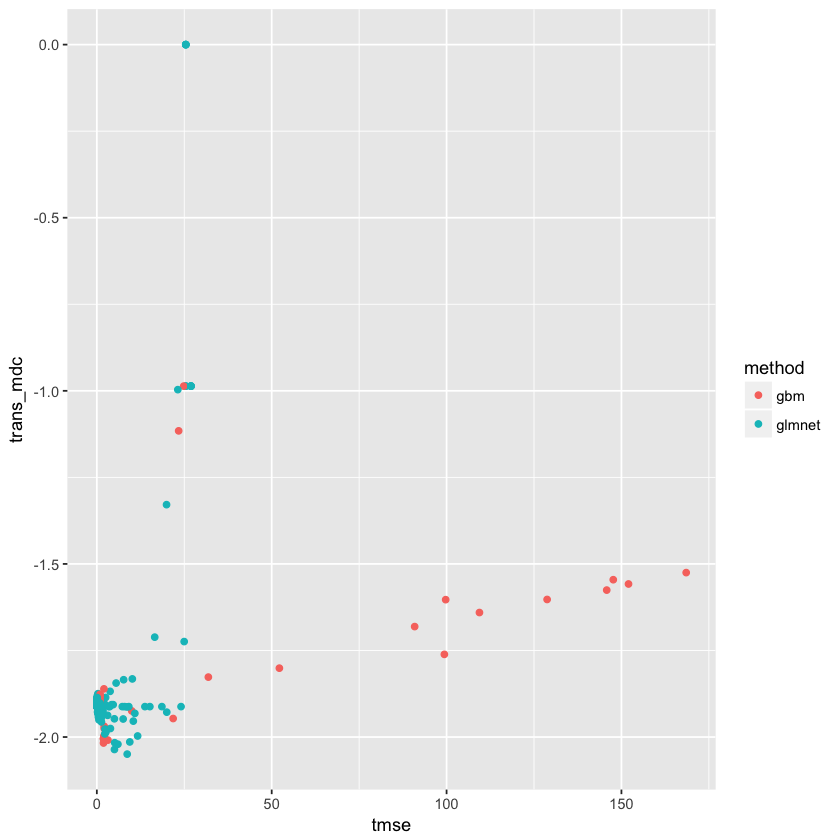

In [136]:
list(val_metrics, true_test_metrics) %>%
    gather(model, metric)


inner_join(true_test_metrics, val_metrics, by="model")%>%
separate(model, c("learner", "model"), sep="\\$") %>%
separate(model, c("method", "params"), sep="@") %$%
qplot(tmse, trans_mdc, color=method)